<a href="https://colab.research.google.com/github/AditiShanmugam/Multi-Modal-Machine-Learning/blob/main/CLIP_FYP_Beverages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import subprocess
 
CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)
 
if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 11.1


In [2]:
!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html
!pip install ftfy regex

import torch

print("Torch version:", torch.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.3 MB/s eta 0:04:02tcmalloc: large alloc 1147494400 bytes == 0x3ab00000 @  0x7f2b9aba0615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████████████▏  | 1055.7 MB 1.2 MB/s eta 0:01:23tcmalloc: large alloc 1434370048 bytes == 0x7f156000 @  0x7f2b9aba0615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

In [3]:
!git clone https://github.com/openai/CLIP.git
%cd CLIP
import clip

Cloning into 'CLIP'...
remote: Enumerating objects: 222, done.
remote: Total 222 (delta 0), reused 0 (delta 0), pack-reused 222
Receiving objects: 100% (222/222), 8.91 MiB | 29.35 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/content/CLIP


In [7]:
# Mount Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [8]:
# make directory to hold images
import os 

#if 'images' not in os.listdir():
!mkdir /content/images/
# !rm -r /content/images/

# unzip and extract
# !cp -r /content/gdrive/MyDrive/Exotic_Food_Dataset/ExoticFood/ /content/images/
!unzip -uq '/content/gdrive/MyDrive/FinalYearProject-Group11/Datasets/Image_Database_Beverages.zip' -d "/content/images"

In [35]:
import os
image_urls = []
labels = []

path = '/content/images/Image_Database_Beverages'


for folder in os.listdir(path):
  if folder != '.DS_Store':
    for file in os.listdir(os.path.join(path, folder)):
      if file != '.DS_Store':
        url = os.path.join(path, folder, file)
        image_urls.append(url)
        name = folder#.replace('_',' ')
        labels.append(name)


print(f'# of images: {len(image_urls)}')
print(f'# of labels: {len(labels)}')

# of images: 271
# of labels: 271


In [36]:
food_types = sorted(set(labels))
print(len(food_types))
food_types

12


['Coke_Zero',
 'Diet_Dr_Pepper',
 'Dole_Orange_Juice',
 'Fanta',
 'Hawaiian_Punch',
 'Kool-Aid',
 'Minute_Maid_Orange',
 'Snapple_Mango_Madness',
 'Sunkist',
 'Tropicana_Apple_Juice',
 'V8_Juice',
 'Welchs_Concord_Grape_Juice']

In [37]:
class_to_idx = {v:k for k,v in enumerate(food_types)}
idx_to_class = {k:v for v,k in class_to_idx.items()}

list_of_targets = [class_to_idx[label] for label in labels]

In [38]:
import pandas as pd
df = pd.DataFrame(list(zip(image_urls, labels, list_of_targets)), columns = ['image_urls', 'labels', 'targets'])

In [43]:
df.head()

,image_urls,labels,targets
0,/content/images/Image_Database_Beverages/Coke_...,Coke_Zero,0
1,/content/images/Image_Database_Beverages/Coke_...,Coke_Zero,0
2,/content/images/Image_Database_Beverages/Coke_...,Coke_Zero,0
3,/content/images/Image_Database_Beverages/Coke_...,Coke_Zero,0
4,/content/images/Image_Database_Beverages/Coke_...,Coke_Zero,0


In [45]:
class CustomDatasetFromImages(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data_info = dataframe
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        self.label_arr = np.asarray(self.data_info.iloc[:, 2])
        self.data_len = len(self.data_info.index)
        self.transforms = transform

    def __getitem__(self, index):
        single_image_name = self.image_arr[index]
        img_as_img = Image.open(single_image_name).convert("RGB")
        tensor_image = self.transforms(img_as_img)
        single_image_label = self.label_arr[index]

        return (tensor_image, single_image_label)

    def __len__(self):
        return self.data_len

In [46]:
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import numpy as np

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

model, preprocess = clip.load("ViT-B/32", device=device) #loading the clip checkpoints
dataset = CustomDatasetFromImages(df, transform=preprocess)

In [27]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import cv2
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(15, 15))

images = []
texts = []
image1 = cv2.imread('/content/images/Image_Database_Beverages/Coke_Zero/Coke _Zero0.jpg')
RGB_img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.imread('/content/images/Image_Database_Beverages/Kool_Aid/Kool-Aid0.jpg')
RGB_img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image3 = cv2.imread('/content/images/Image_Database_Beverages/Sunkist/Sunkist0.jpg')
RGB_img3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
image4 = cv2.imread('/content/images/Image_Database_Beverages/Fanta/Fanta0.jpg')
RGB_img4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)
rows = 4
columns = 1

fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(RGB_img1)
plt.axis('off')
plt.title("This is a photo of coke  zero, a diet cola produced by The Coca-Cola Company", fontsize=15)
fig.add_subplot(rows, columns, 2)
plt.imshow(RGB_img2)
plt.axis('off')
plt.title("This is a photo of a kool-aid, a flavored drink mix owned by Kraft Heinz based in Chicago, Illinois", fontsize=15)
fig.add_subplot(rows, columns, 3)
plt.imshow(RGB_img3)
plt.axis('off')
plt.title("This is a photo of sunkist, a primarily orange flavored soft drinks", fontsize=15)
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
# showing image
plt.imshow(RGB_img4)
plt.axis('off')
plt.title("This is a photo of  fanta, a fruit-flavored carbonated soft drinks created by Coca-Cola", fontsize=15)
plt.tight_layout()

error: ignored

<Figure size 1080x1080 with 0 Axes>

#Linear Probe

In [50]:
torch.manual_seed(42)

def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=50)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [48]:
features, labels = get_features(dataset)

100%|██████████| 6/6 [00:46<00:00,  7.77s/it]


In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

#Evaluate L2 regularization strengths for reducing features in final model 
C = [1, 5, 10, 11, 12, 13, 14, 15] # As C decreases, more coefficients go to zero

for c in C:
    clf = LogisticRegression(penalty='l2', C=c, solver='liblinear', class_weight="balanced")

    # using data before splitting (X=features) and (y=labels)
    scores = np.mean(cross_val_score(clf, features, labels, cv=5, scoring="accuracy"))  #<-- add this
    print(scores)  #<-- add this

0.9852525252525253
0.9852525252525253
0.988956228956229
0.988956228956229
0.988956228956229
0.988956228956229
0.988956228956229
0.988956228956229


In [52]:
seed = [0, 42, 96, 100, 201]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, #Change test size when deploying model
                                                    random_state=seed[1], stratify=labels)

In [53]:
model = LogisticRegression(random_state=seed[1], penalty='l2', 
                         C=1, solver='liblinear', 
                         class_weight="balanced")


scores = cross_val_score(model, features, 
                         labels, cv=10, 
                         scoring="accuracy")

print("Scores are:")
print(scores)
print(f"======\nMean score is: {np.mean(scores)}")

Scores are:
[1.         0.96296296 0.96296296 1.         1.         1.
 1.         1.         1.         0.96296296]
Mean score is: 0.9888888888888889


In [54]:
classifier = LogisticRegression(random_state=seed[1], C=1, verbose=1, solver='liblinear', penalty='l2')
classifier.fit(X_train, y_train)

[LibLinear]

LogisticRegression(C=1, random_state=42, solver='liblinear', verbose=1)

In [55]:
def get_topk(classifier, X_test, y_test, top_k = (1, 5)):
  predictions = classifier.predict(X_test)
  probs = classifier.predict_proba(X_test)
  _max = max(top_k)
  best = np.argsort(probs, axis=1)[:,-(_max):]
  pred = torch.from_numpy(np.transpose(best))
  target = torch.from_numpy(y_test)
  correct = pred.eq(target.view(1, -1).expand_as(pred))
  res = []
  for k in top_k:
    correct_k = correct[:k].reshape(-1).float().sum(0)
    res.append(correct_k.mul_(100.0 / len(y_test)))
  inter_tensor = torch.stack(res)
  top5 = inter_tensor.data[1].item()
  top1 = np.mean((y_test == predictions))*100
  print(f'Top 1 accuracy is {top1}'.format(top1))
  print(f'Top {_max} accuracy is {top5}'.format(_max, top5))

In [56]:
get_topk(classifier, X_test, y_test, top_k = (1, 5))

Top 1 accuracy is 98.78048780487805
Top 5 accuracy is 100.0


In [57]:
from sklearn.metrics import confusion_matrix

predictions = classifier.predict(X_test)
conf_mat=confusion_matrix(y_test, predictions)
conf_mat = conf_mat / conf_mat.astype(np.float).sum(axis=1, keepdims=True)
# conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


''

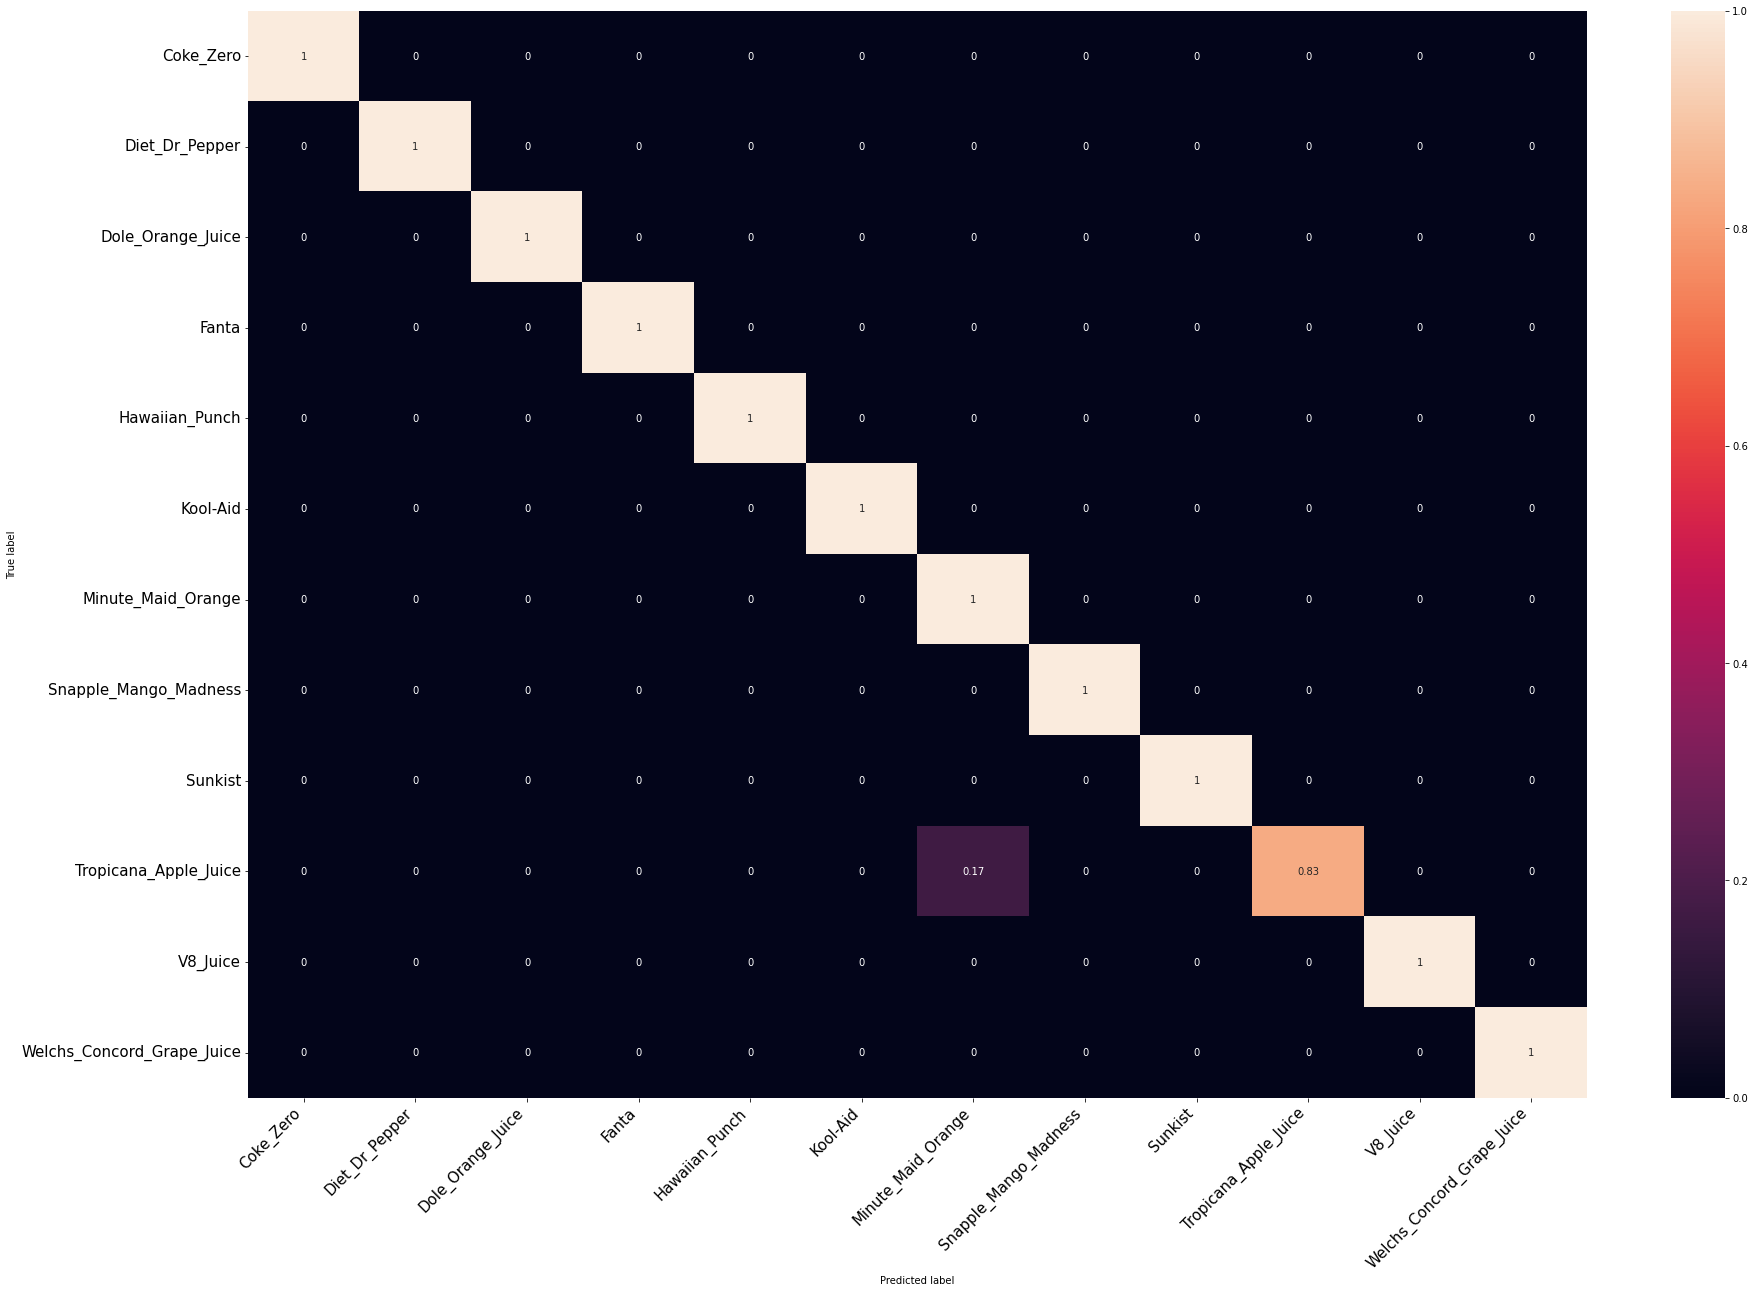

In [58]:
pd.set_option('display.max_rows', None)
import seaborn as sns

plt.figure(figsize=(30,20))

class_names = food_types
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names).astype(float)
df_cm
heatmap = sns.heatmap(df_cm, annot=True) #, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;

#Zero-Shot

In [59]:
model, preprocess = clip.load("ViT-B/32", device=device) #loading the clip checkpoints
dataset = CustomDatasetFromImages(df, transform=preprocess)

torch.manual_seed(42)

def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=8)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    # return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()
    
    #return tensor for images and array for labels
    return torch.cat(all_features), torch.cat(all_labels).cpu().numpy()

In [60]:
image_features, labels = get_features(dataset)

100%|██████████| 34/34 [00:57<00:00,  1.68s/it]


In [61]:
print(image_features.shape)
print(labels.shape)

torch.Size([271, 512])
(271,)


In [80]:
texts = {'Hawaiian_Punch': 'This is a photo of hawaiian punch, a juice with natural fruit juices and flavors, including such tropical favorites as pineapple, passion fruit, papaya, and guava.',
              'Coke_Zero': 'This is a photo of coke  zero, a diet cola produced by The Coca-Cola Company ',
              'V8_Juice': 'This is a photo of v8 juice,  drink that contains jucies from 8 vegetables',
              'Fanta': 'This is a photo of  fanta, a fruit-flavored carbonated soft drinks created by Coca-Cola ',
              'Snapple_Mango_Madness ': 'This is a photo of snapple mango madness, a sweet, fruity, and delicious Mango drink ',
              'Minute_Maid_Orange': 'This is a photo of minute maid orange, a drink that contains real orange juice sourced from Florida ',
              'Welchs_Concord_Grape_Juice': 'This is a photo of a Welchs concord grape juice,  a drink made from an original American super fruit that helps support a healthy heart. ',
              'Diet_Dr_Pepper': 'This is a photo of a diet dr pepper, a carbonated soft drink with no added sugar "',
              'Tropicana_Apple_Juice': 'This is a photo of tropicana apple juice, a 100% Apple fruit juice with no added sugar for a healthy you ',
              'Sunkist': 'This is a photo of sunkist, a primarily orange flavored soft drinks ',
              'Dole_Orange_Juice ': 'This is a photo of a dole orange juice, a drink made of  100% Juice and provides you with the sweet, tangy taste of oranges ',
              'Kool-Aid': 'This is a photo of a kool-aid, a flavored drink mix owned by Kraft Heinz based in Chicago, Illinois'}

In [89]:
texts = [f"This is a photo of {c}, a type of exotic food. It is exotically delicious." for c in food_types]

In [90]:
text_inputs = clip.tokenize(texts).to(device)

In [91]:
def get_topk(text_inputs, image_features, labels, top_k=(1,2)):
  
  torch.cuda.empty_cache()

  with torch.no_grad():
    text_features = model.encode_text(text_inputs).float()
    # image_features = image_features
    # image_features = torch.from_numpy(image_features)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    _max = max(top_k)

    test_probs, test_labels = text_probs.cpu().topk(1, dim=-1) # calculate for confusion matrix
    predictions = np.concatenate(test_labels.cpu().numpy()) # calculate for confusion matrix
    
    top_probs, top_labels = text_probs.cpu().topk(_max, dim=-1) # calculate for actual top-1, top-5
    pred = top_labels.t()
    target = torch.from_numpy(labels)
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in top_k:
      correct_k = correct[:k].reshape(-1).float().sum(0)
      res.append(correct_k.mul_(100.0 / len(labels)))
    inter_tensor = torch.stack(res)
    top1 = inter_tensor.data[0].item()
    top2 = inter_tensor.data[1].item()
    print(f'Top 1 accuracy is {top1:.2f}'.format(top1)) # print top-1
    print(f'Top {_max} accuracy is {top2:.2f}'.format({_max}, top2)) # print top-2

    return predictions # return for confusion matrix

In [92]:
predictions = get_topk(text_inputs, image_features, labels, top_k=(1,2))

Top 1 accuracy is 93.36
Top 2 accuracy is 96.68


In [93]:
predictions = get_topk(text_inputs, image_features, labels, top_k=(1,3))

Top 1 accuracy is 93.36
Top 3 accuracy is 97.79


In [94]:
predictions = get_topk(text_inputs, image_features, labels, top_k=(1,5))

Top 1 accuracy is 93.36
Top 5 accuracy is 98.89


In [95]:
predictions.shape

(271,)

In [96]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(labels, predictions)
conf_mat = conf_mat / conf_mat.astype(np.float).sum(axis=1, keepdims=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


''

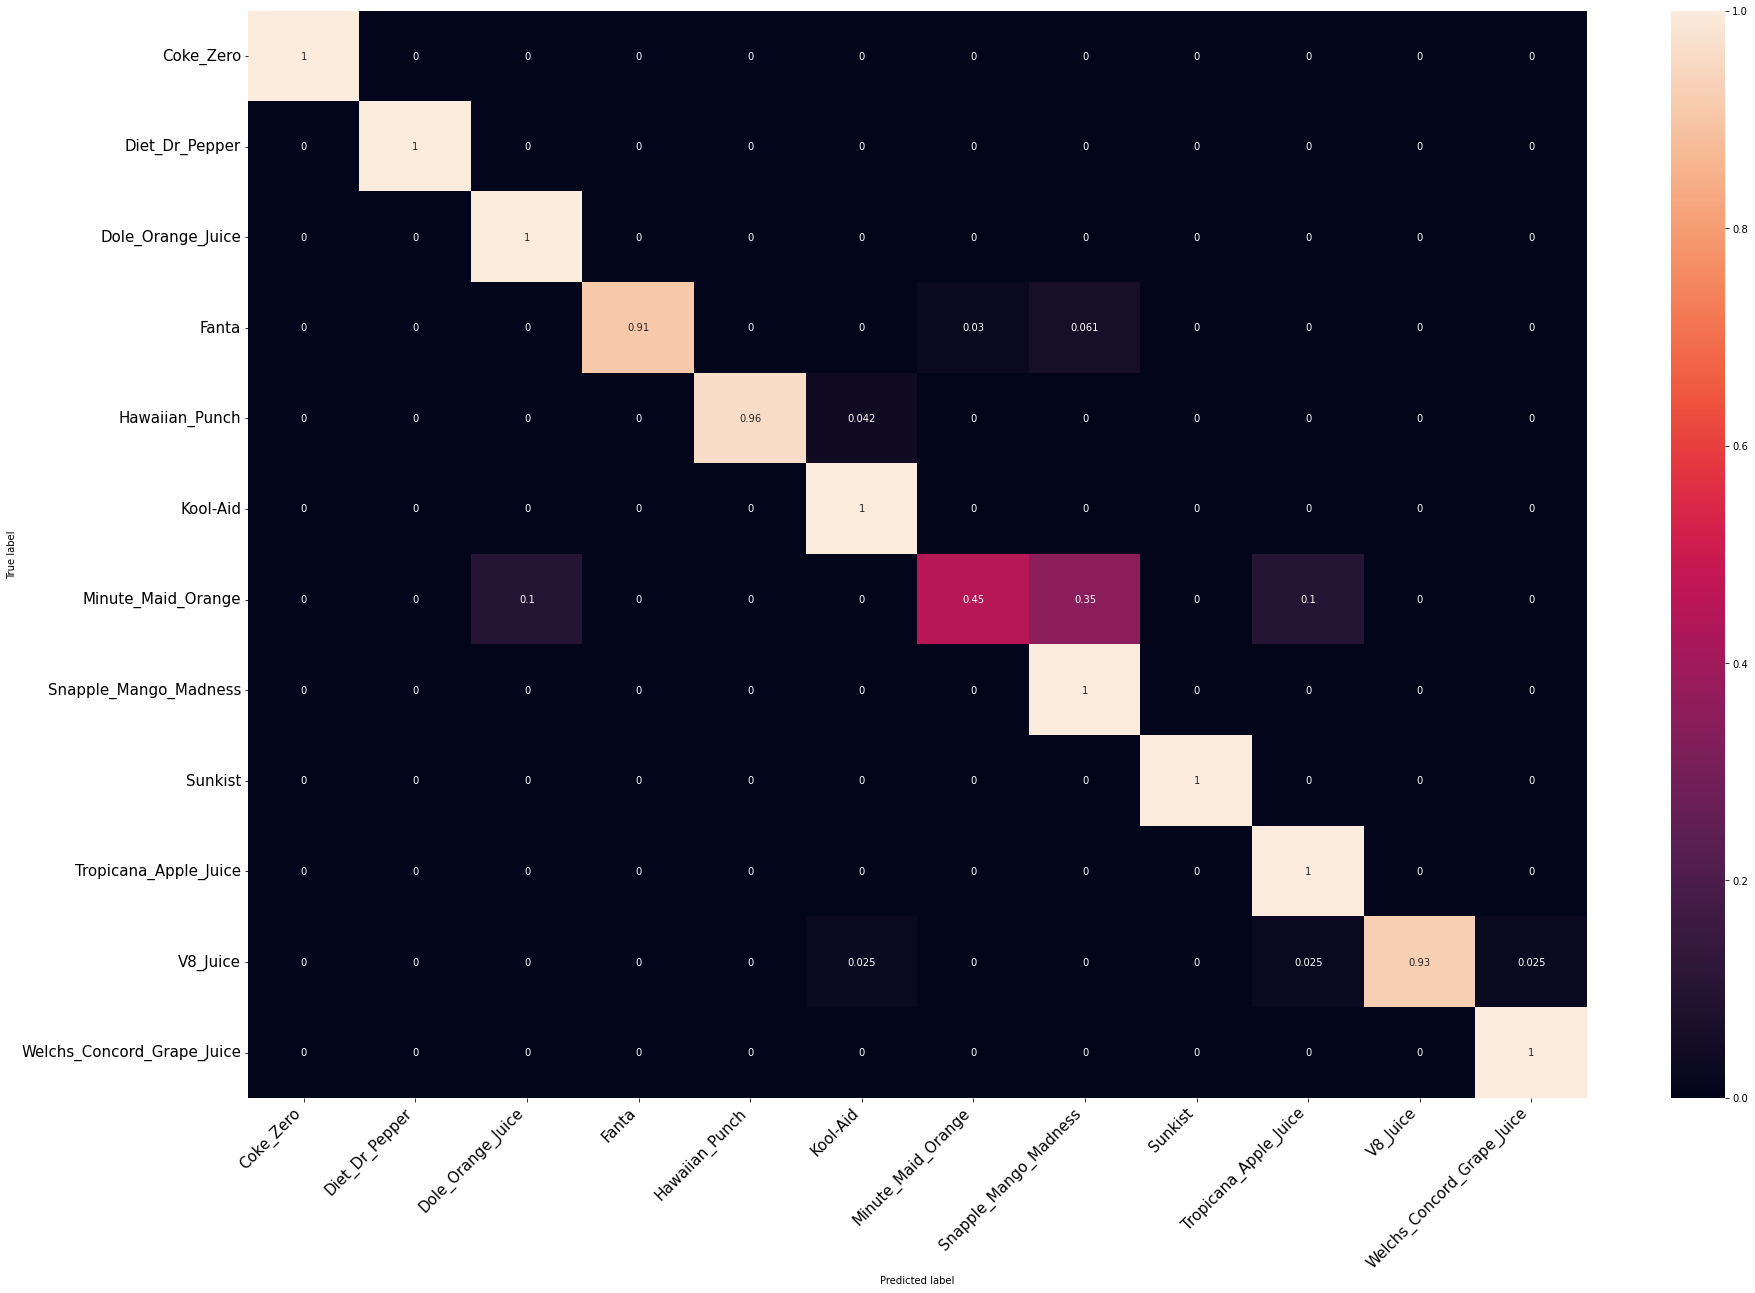

In [97]:
# %load_ext google.colab.data_table

pd.set_option('display.max_rows', None)
import seaborn as sns

plt.figure(figsize=(30,20))

class_names = food_types

df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names).astype(float)
heatmap = sns.heatmap(df_cm, annot=True) #, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;